# Tools 2 Final Project

Jen Lee
Connie Chang

In [1]:
import pandas as pd
import geopandas as gpd
import re
import numpy as np
import seaborn as sns
from shapely.geometry import Point
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

## Data Gathering

#### AirBnb Data

Source: http://insideairbnb.com/get-the-data.html

|Date Compiled |County/City|File Name   |Description |
|:-------------|:---------:|:----------:|-----------:|
|29 March, 2021|Denver     |listings.csv|Summary information and metrics for listings in Denver (good for visualisations).|
|29 March, 2021|Denver     |reviews.csv|Summary Review data and Listing ID (to facilitate time based analytics and visualisations linked to a listing).|
|N/A|Denver     |neighbourhoods.csv| Neighbourhood list for geo filter. Sourced from city or open source GIS files.|
|N/A|Denver     |neighbourhoods.geojson| GeoJSON file of neighbourhoods of the city.|

#### Other Data

|Source |File Name   |Description | URL |
|:-------------|:---------:|:----------:|-----------:|
|Wikipedia|neighbourhoods_den.csv   |Groups the Denver Neighbourhoods into Areas| https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Denver |



In [2]:
# listings.csv
listings = pd.read_csv("./data/denver_03_29_2021/listings.csv")
print(f"listings shape: {listings.shape}")
listings.sample(3)

listings shape: (3394, 74)


,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
1868,37906008,https://www.airbnb.com/rooms/37906008,20210329150448,2021-03-30,★French Consulate Mansion/5BR/Denver/Historic1...,"Perfect place to social distance, work, and va...","The former French Consulate Mansion, Denver’s ...",https://a0.muscache.com/pictures/0fd6c8b9-654a...,287154690,https://www.airbnb.com/users/show/287154690,...,10.0,10.0,9.0,2019-BFN-0008062,t,1,1,0,0,2.24
1808,36928877,https://www.airbnb.com/rooms/36928877,20210329150448,2021-03-31,Lovely condo near the Capitol-30 day minimum stay,This 10th floor condo in an attractive buildin...,The condo is located six blocks from the 16th ...,https://a0.muscache.com/pictures/00f4b852-96c8...,69874010,https://www.airbnb.com/users/show/69874010,...,10.0,10.0,10.0,NaN,t,1,1,0,0,0.44
2611,45302234,https://www.airbnb.com/rooms/45302234,20210329150448,2021-03-31,Fully Remodeled Private Suite in Athmar Park,Spacious 1 Bedroom/ 1 Bathroom newly remodeled...,13 minute walk to Huston Lake park for beautif...,https://a0.muscache.com/pictures/4ff4141a-34ad...,11652812,https://www.airbnb.com/users/show/11652812,...,10.0,10.0,9.0,2020-BFN-0005729,f,1,1,0,0,1.07


In [3]:
# reviews.csv
reviews = pd.read_csv("./data/denver_03_29_2021/reviews.csv")
reviews.sample(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments
159666,34017701,565706017,2019-11-17,294205553,Thomas,Everything was perfect.
155014,32406972,664439333,2020-09-14,177410783,Cierra,The property was absolutely awesome and so coz...
179826,42381505,726875732,2021-01-25,136233203,Tuan,"Devin and Cass are super nice, very good locat..."


In [4]:
# neighbourhoods.csv
neighborhoods = pd.read_csv("./data/denver_03_29_2021/neighbourhoods.csv")
neighborhoods.sample(3)

,neighbourhood_group,neighbourhood
34,NaN,Harvey Park South
3,NaN,Barnum
22,NaN,DIA


In [5]:
# neighbourhoods.geojson
neighborhoods_gdf = gpd.read_file("./data/denver_03_29_2021/neighbourhoods.geojson")
neighborhoods_gdf.sample(3)

,neighbourhood,neighbourhood_group,geometry
22,Platt Park,None,"MULTIPOLYGON (((-104.97342 39.68982, -104.9734..."
65,Berkeley,None,"MULTIPOLYGON (((-105.02519 39.78439, -105.0251..."
34,Southmoor Park,None,"MULTIPOLYGON (((-104.90186 39.62409, -104.9040..."


In [6]:
# neighbourhoods_den.csv
neighbourhoods_group = pd.read_csv("./data/neighbourhoods_den.csv")
neighbourhoods_group.sample(3)

,neighbourhood_cleansed,neighbourhood_group
72,Mar Lee,West
75,Valverde,West
6,City Park West,Central


## Data Cleaning

In [7]:
# remove unneeded columns from listings 
listings.drop(columns=["picture_url", "host_url", "host_thumbnail_url", "host_picture_url", "license", 'scrape_id', 
               'listing_url','last_scraped', 'neighborhood_overview','host_verifications' ,
               'host_about', 'host_thumbnail_url','host_neighbourhood', 'neighbourhood', 'name',
               'description','host_name', 'calendar_last_scraped'], axis=1, inplace=True)

In [8]:
# Clean up the "bathrooms_text" column to make two new columns - number of bathrooms, and a boolean column to indicate if bthrooms are private
def get_bathrooms_num(x):
    if type(x) != str:
        return 0.0
    elif x == "Shared half-bath" or x == "Half-bath":
        return 0.5
    elif "shared bath" in x:
        return float(x.strip("s").strip("shared bath"))
    elif "private bath" in x:
        return float(x.strip("s").strip("private bath"))
    elif "bath" in x:
        return float(x.strip("s").strip("bath"))
    else:
        return 0.0
    
# Returns "t" & "f" beacuse that's how the other booleans are formatted
def get_is_private_bathroom(x):
    if type(x) != str:
        return np.NaN
    elif "shared" in x:
        return "f"
    else:
        return "t"

listings["bathrooms"] = listings["bathrooms_text"].apply(lambda x: get_bathrooms_num(x))
listings["private_bathroom"] = listings["bathrooms_text"].apply(lambda x: get_is_private_bathroom(x))
listings = listings.drop("bathrooms_text", axis=1)

In [9]:
# Convert the latitude & longitude values to Point() values, to be used later for plotting
listings["coordinates"] = [Point(xy) for xy in zip(listings.longitude, listings.latitude)]
listings = listings.drop("longitude", axis=1)
listings = listings.drop("latitude", axis=1)

In [10]:
# For amenities. We want to explode that array out and convert the types of amenity to a "t/f" column showing if they have that amenity

all_amenities = set()

# First build an array of all the amenity types
for index, row in listings.iterrows():
    # Convert String representation of list to a list
    amenities = row["amenities"].replace('"', '').strip('][').split(', ')
    for item in amenities:
        all_amenities.add(item)
    
all_amenities

{'1 space',
 '120\\ HDTV with Netflix',
 '2 burner stovetop electric stove',
 '2 spaces',
 '2-5 years old',
 '30\\ HDTV with Netflix',
 '30\\ HDTV with Roku',
 '32\\ HDTV with Amazon Prime Video',
 '32\\ HDTV with Apple TV',
 '32\\ HDTV with Netflix',
 '32\\ HDTV with premium cable',
 '36\\ HDTV with Netflix',
 '37\\ TV',
 '4-burner cooktop (above microwave) electric stove',
 '40\\ HDTV',
 '40\\ HDTV with Amazon Prime Video',
 '40\\ HDTV with Chromecast',
 '40\\ HDTV with Netflix',
 '40\\ HDTV with standard cable',
 '40\\ TV',
 '40\\ TV with Roku',
 '41\\ TV with Chromecast',
 '42\\ HDTV with Amazon Prime Video',
 '42\\ HDTV with HBO Max',
 '42\\ TV',
 '43\\ HDTV with Amazon Prime Video',
 '44\\ HDTV with Netflix',
 '45\\ HDTV with Amazon Prime Video',
 '45\\ HDTV with HBO Max',
 '46\\ HDTV with Amazon Prime Video',
 '46\\ HDTV with Netflix',
 '48\\ HDTV with standard cable',
 '49\\ HDTV with Roku',
 '5-10 years old',
 '50\\ HDTV with Amazon Prime Video',
 '50\\ HDTV with Netflix',
 '5

In [11]:
## oof, that's a lot of ameneites, lets try to simple it down by hand
amenities = ["Air conditioning", "BBQ grill", "Baby bath", "Baby monitor", "Baby safety gates", "Backyard", 
             "Beachfront", "Bidet", "Bikes", "Board games", "Breakfast", "Cable", "Coffee", "Crib", "Dishwasher", "Dryer",
             "Fire pit", "Free parking", "Free wifi", "Game console", "Gym", "HGTV", "Heating", "High chair", 
            "Hot tub", "Luggage dropoff allowed", "Netflix", "Pets allowed", "Piano", "Ping pong table", "Pool", 
             "Pool table", "private entrance", "Private gym", "Private pool", "Private sauna", "Sauna",
             "Shared hot tub", "Shared outdoor heated pool", "Shared outdoor heated rooftop pool", "Shared outdoor pool",
            "Shared pool", "Shared sauna", "TV", "Washer", "Wifi", "Window AC unit"]


# Because a lot of these amenities have multiple similar forms, we'll check for them recursively
def check_for_amenity(amenities_str, amenity_to_check_for):
    amenities_list = amenities_str.replace('"', '').strip('][').split(', ')
    # convert list to lower so it's easer to check
    amenities_list = [each_string.lower() for each_string in amenities_list]
    for al in amenities_list:
        if amenity_to_check_for.lower() in al:
            # Check for pool & pool table seperate so those are very different
            if amenity_to_check_for.lower() == "pool":
                if "pool table" in al:
                    return "f"
                return "t"
            return "t"
    return "f"

# Now create column for each amenity
for a in amenities:
    listings[a] = listings["amenities"].apply(lambda al: check_for_amenity(al, a))
            
listings = listings.drop("amenities", axis = 1)
listings[amenities].sample(3)

,Air conditioning,BBQ grill,Baby bath,Baby monitor,Baby safety gates,Backyard,Beachfront,Bidet,Bikes,Board games,...,Shared hot tub,Shared outdoor heated pool,Shared outdoor heated rooftop pool,Shared outdoor pool,Shared pool,Shared sauna,TV,Washer,Wifi,Window AC unit
1586,t,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,t,t,t,f
217,t,t,f,f,f,t,f,f,f,f,...,f,f,f,f,f,f,t,t,t,f
2772,f,t,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,t,t,t,f


### Add neighbourhoods_group

In [12]:
# Merge neighbourhoods_group df into listings
listings = pd.merge(listings, neighbourhoods_group, on='neighbourhood_cleansed',  
         how='left', validate='m:1')

listings[['neighbourhood_cleansed','neighbourhood_group']].sample(5)

,neighbourhood_cleansed,neighbourhood_group
2674,CBD,Central
1302,West Colfax,West
2986,West Colfax,West
3061,City Park West,Central
2789,Sunnyside,Northwest


### Price Field
'price' field is with type: object. It needs to remove '$' and ',' then convert to numeric.

In [13]:
print(f"listing price initial type: {listings.price.dtype}")

# drop the record with price = 0
listings = listings[listings['price']!='$0.00']

# remove '$' and ','
listings['price'] = listings['price'].str.strip('$')
listings['price'] = listings['price'].str.replace(',', '')

# convert to numeric
listings['price'] = pd.to_numeric(listings['price'])

print(f"listing price after cleaning type: {listings.price.dtype}")

listings['price'].describe()

listing price initial type: object
listing price after cleaning type: float64


count    3393.000000
mean      157.756263
std       244.777158
min        22.000000
25%        79.000000
50%       115.000000
75%       175.000000
max      9999.000000
Name: price, dtype: float64

### Convert Data Types
1. Convert to numeric: ```host_response_rate``` and ```host_acceptance_rate``` are object, remove '%' and convert to numeric
2. Convert to Ordinal: ```host_since```, ```first_review```, ```last_review```

In [14]:
# Remove % sign and convert the data type to numeric
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str[:-1])
listings['host_acceptance_rate'] = pd.to_numeric(listings['host_acceptance_rate'].str[:-1])

# Datetime format:
listings.host_since = pd.to_datetime(listings.host_since, format='%Y-%m-%d')
listings.first_review = pd.to_datetime(listings.first_review, format='%Y-%m-%d')
listings.last_review = pd.to_datetime(listings.last_review, format='%Y-%m-%d')

# Fill NA with 03/29/2012 (date data was scraped since we know they were at least a host since then)
listings['host_since'] = listings['host_since'].fillna(pd.datetime(year=2021, month=3, day=29))
listings['first_review'] = listings['first_review'].fillna(pd.datetime(year=2021, month=3, day=29))
listings['last_review'] = listings['last_review'].fillna(pd.datetime(year=2021, month=3, day=29))

# To Ordinal
listings['host_since'] = listings['host_since'].apply(lambda x: x.toordinal())
listings['first_review'] = listings['first_review'].apply(lambda x: x.toordinal())
listings['last_review'] = listings['last_review'].apply(lambda x: x.toordinal())

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  del sys.path[0]


### Fill in NA
1. ```Bedrooms``` field with blank are the ones that either a studio, or an open space without separate room as a bedroom, so we fill it with 0.
2. ```Beds``` field with blank typically means that the listing host missed the field. The main point of airbnb is bed, we'd assume they have at least 1 bed, so fill in the blank ones with 1.
3. ```Reviews_per_month``` field with blank means there's no review at all. Thus, the ```first_review``` and ```last_review``` fields are both blank. We'd fill the ```reviews_per_month``` with 0.
4. Fill numerical columns with mean.
5. Fill categorical columns with 'missing'.

In [15]:
# FunctionTransformer for fill NA 
from sklearn.preprocessing import FunctionTransformer
def custom_transformation(df):
    df['bedrooms'].fillna(0, inplace=True)
    df['beds'].fillna(1, inplace=True)
    df['reviews_per_month'].fillna(0, inplace=True)

ft = FunctionTransformer(func=custom_transformation, validate=False)
ft.fit_transform(listings)

In [16]:
#Numeric columns :
numFeatures = listings.select_dtypes(include=['int64', 'float64']).columns
numFeatures

Index(['id', 'host_id', 'host_since', 'host_response_rate',
       'host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'neighbourhood_group_cleansed',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calc

In [17]:
listings[numFeatures] = listings[numFeatures].fillna(listings[numFeatures].mean()) # fill numberical columns with mean

In [18]:
# Categorical columns :
# Drop coortinates then get any remaining columns
catFeatures = listings.drop(['coordinates'], axis=1).select_dtypes(include=['object']).columns
catFeatures

Index(['host_location', 'host_response_time', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type',
       'has_availability', 'instant_bookable', 'private_bathroom',
       'Air conditioning', 'BBQ grill', 'Baby bath', 'Baby monitor',
       'Baby safety gates', 'Backyard', 'Beachfront', 'Bidet', 'Bikes',
       'Board games', 'Breakfast', 'Cable', 'Coffee', 'Crib', 'Dishwasher',
       'Dryer', 'Fire pit', 'Free parking', 'Free wifi', 'Game console', 'Gym',
       'HGTV', 'Heating', 'High chair', 'Hot tub', 'Luggage dropoff allowed',
       'Netflix', 'Pets allowed', 'Piano', 'Ping pong table', 'Pool',
       'Pool table', 'private entrance', 'Private gym', 'Private pool',
       'Private sauna', 'Sauna', 'Shared hot tub',
       'Shared outdoor heated pool', 'Shared outdoor heated rooftop pool',
       'Shared outdoor pool', 'Shared pool', 'Shared sauna', 'TV', 'Washer',
       'Wifi', 'Window AC 

In [19]:
listings[catFeatures] = listings[catFeatures].fillna('missing') # fill categorical columns with 'missing'

### Dropping Any Remaining Data that can't be Cleaned
1. Drop all NA columns ```neighbourhood_group_cleansed```, ```calendar_updated```
2. There are 4 records with NA in the ```bathrooms_text``` field, which be previously convertyed to ```private_bathroom```.
3. Drop records with NA in ```host_identity_verified``` as these may not be verified to be trust worthy hosts.

In [20]:
listings.drop(['neighbourhood_group_cleansed','calendar_updated'], axis=1, inplace=True)

# drop records with host_verified na and private_bathroom na (no data from bathroom_text)
listings.dropna(subset=['private_bathroom'], inplace=True)
listings.dropna(subset=['host_identity_verified'], inplace=True)

In [21]:
print(f"after dropping listings df shape: {listings.shape}")
listings.info()

after dropping listings df shape: (3393, 101)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3393 entries, 0 to 3393
Columns: 101 entries, id to neighbourhood_group
dtypes: float64(18), int64(23), object(60)
memory usage: 2.6+ MB


In [22]:
listings.sample(3)

,id,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,...,Shared outdoor heated pool,Shared outdoor heated rooftop pool,Shared outdoor pool,Shared pool,Shared sauna,TV,Washer,Wifi,Window AC unit,neighbourhood_group
578,15869291,114383856,736361,"Wheat Ridge, Colorado, United States",within a day,80.0,85.000000,f,7.0,7.0,...,f,f,f,f,f,t,t,t,f,Northwest
2811,46156938,186966466,736813,"Denver, Colorado, United States",within an hour,100.0,100.000000,t,1.0,1.0,...,f,f,f,f,f,t,t,t,f,North
3196,48241365,61974684,736030,"Sydney, New South Wales, Australia",within a few hours,100.0,90.269435,f,0.0,0.0,...,f,f,f,f,f,t,t,t,f,Northwest


## Visualizations

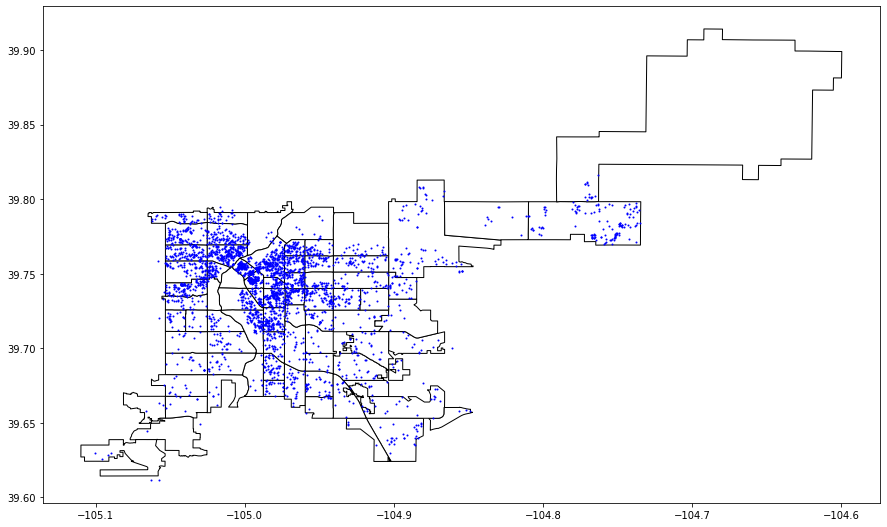

In [23]:
# Plot all the coordinates from the listings on the neighborhoods map
listings_gdf = gpd.GeoDataFrame(listings, geometry="coordinates")

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

ax = neighborhoods_gdf.plot(color="white", edgecolor="black", ax=ax)
listings_gdf.plot(ax=ax, color="blue", markersize=1)

plt.show()

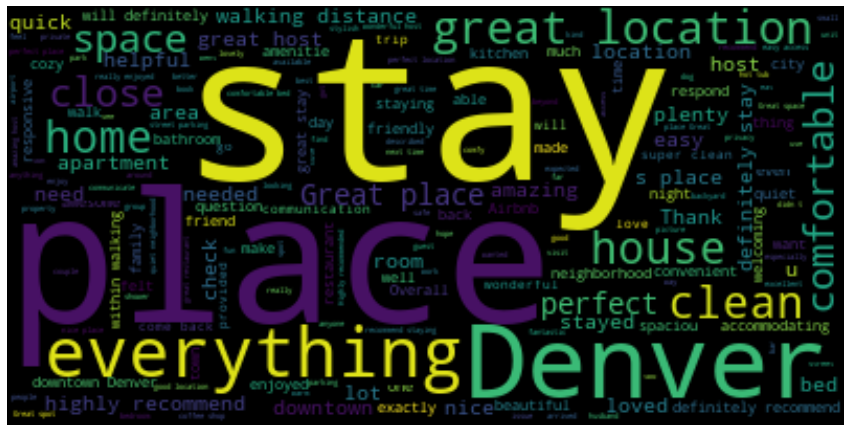

In [24]:
# make a word cloud with all the reviews text

# function to lump all the text together
def lumpText(text_array):
    lump = ""
    for i in text_array:
        lump += str(i) + " "
    return lump

# generate wordcloud
reviews_lump_text = lumpText(reviews["comments"].values)
reviews_wordcloud = WordCloud().generate(reviews_lump_text)

# plot
plt.figure(figsize=(15,10))
plt.imshow(reviews_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Neighbourhood price box plot


<AxesSubplot:xlabel='neighbourhood_group', ylabel='price'>

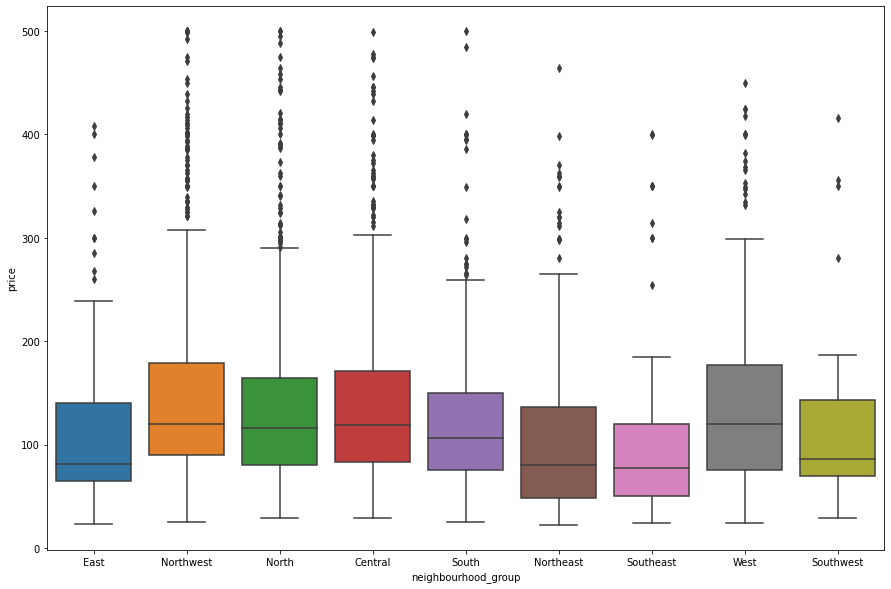

In [25]:
plt.figure(figsize=(15,10))
sns.boxplot(y='price',x='neighbourhood_group', data = listings[listings['price']<=500])

# Model

### Convert Categoircal Features to Numberic with LabelEncoder()

In [26]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values
for cat in catFeatures:
    # Save neighbourhoog_group_mapping for later
    listings[cat] = labelencoder.fit_transform(listings[cat])
    if cat == 'neighbourhood_group':
        neighbourhood_group_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))

listings[catFeatures].sample(3)

,host_location,host_response_time,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,has_availability,instant_bookable,...,Shared outdoor heated pool,Shared outdoor heated rooftop pool,Shared outdoor pool,Shared pool,Shared sauna,TV,Washer,Wifi,Window AC unit,neighbourhood_group
272,35,4,0,2,2,9,2,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1835,35,1,0,2,0,52,6,0,1,0,...,0,0,0,0,0,0,0,1,0,5
2804,8,0,0,2,2,39,2,0,1,0,...,0,0,0,0,0,1,1,0,0,6


### Splitting data into test train

In [27]:
from sklearn.model_selection import train_test_split

# Dependent variable: neighbourhood_group
y = listings['neighbourhood_group']

# Drop dependent variable and other variables that would tamper the results
X = listings.drop(['neighbourhood_group', 'id', 'host_id', 'neighbourhood_cleansed', 'coordinates'], axis=1)

In [28]:
X.columns

Index(['host_since', 'host_location', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_

In [29]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Fit Initial Model

In [30]:
# Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=50)

# Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=50)

In [31]:
y_pred = rf.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 2])

## Model Evaluation

In [32]:
from sklearn import metrics

# First evaluate inital model to get a feel of the metrics
print('n_estimators = 50')
print('\tMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('\tMean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

n_estimators = 50
	Mean Absolute Error: 1.7504911591355599
	Mean Squared Error: 7.361493123772102
	Root Mean Squared Error: 2.7132071656569283


In [33]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[245   1  16   3  47   1   2   0   4]
 [ 20   3   7   4  12   1   0   0   3]
 [ 70   3  55   3  34   3   0   0   2]
 [ 20   1  11  31  24   1   0   0   0]
 [ 83   2  37   2  90   2   0   0   5]
 [ 21   2   6   2  26   7   0   0   1]
 [  5   0   0   4   2   0   4   0   0]
 [  2   0   4   0   3   0   1   0   0]
 [ 27   0  12   4  18   1   0   0  18]]
              precision    recall  f1-score   support

           0       0.50      0.77      0.60       319
           1       0.25      0.06      0.10        50
           2       0.37      0.32      0.35       170
           3       0.58      0.35      0.44        88
           4       0.35      0.41      0.38       221
           5       0.44      0.11      0.17        65
           6       0.57      0.27      0.36        15
           7       0.00      0.00      0.00        10
           8       0.55      0.23      0.32        80

    accuracy                           0.44      1018
   macro avg       0.40      0.28      0.30      101

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
# Make Evaluation Dataframe
evaluation = pd.DataFrame({'n_estimators': [],
                           'Mean Absolute Error':[],
                           'Mean Squared Error':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'Accuracy':[]})

# Make for loop to graph RMSE & Accuracy for different n_estimators
for i in range(5, 201, 5):
    # Make Classifier & Fit
    rf = RandomForestClassifier(n_estimators=i)
    rf.fit(X_train, y_train)
    
    # Predict
    y_pred = rf.predict(X_test)
    
    # Calculate metrics
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    
    # append to evaluation data frame
    r = evaluation.shape[0]
    evaluation.loc[r] = [i,mae,mse,rmse,accuracy]

In [35]:
# Show evaluation dataframe
evaluation.sample(3)

,n_estimators,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error (RMSE),Accuracy
2,15.0,1.796660,7.490177,2.736819,0.428291
5,30.0,1.743615,7.236739,2.690119,0.448919
24,125.0,1.674853,6.873281,2.621694,0.462672


<AxesSubplot:xlabel='n_estimators'>

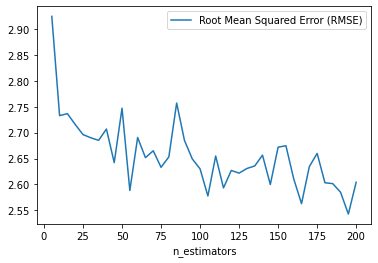

In [36]:
# Plot RMSE
evaluation.plot(kind='line',x='n_estimators',y='Root Mean Squared Error (RMSE)')

<AxesSubplot:xlabel='n_estimators'>

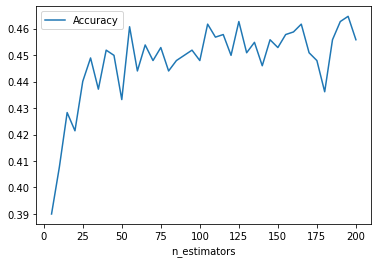

In [37]:
# Plot Accuracy
evaluation.plot(kind='line',x='n_estimators',y='Accuracy')

<AxesSubplot:xlabel='n_estimators'>

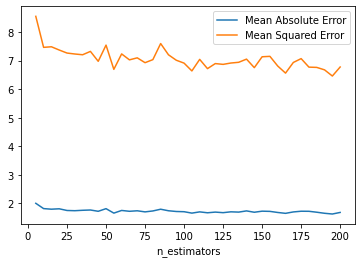

In [38]:
# Plot other Metrics
evaluation.plot(kind='line',x='n_estimators',y=['Mean Absolute Error', 'Mean Squared Error'])

## Model Selection

In [39]:
# Get row in dataframe where accuracy was the highest
best_model = evaluation.sort_values(by = "Accuracy", ascending = False).head(1)
best_model

,n_estimators,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error (RMSE),Accuracy
38,195.0,1.627701,6.464637,2.542565,0.464637


In [40]:
best_n = int(best_model['n_estimators'].iloc[0])
print("We saw best performace on a RandomForestClassifier with n_estimators = ", best_n)

We saw best performace on a RandomForestClassifier with n_estimators =  195


In [41]:
# Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=best_n)

# Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=195)

In [42]:
y_pred = rf.predict(X_test)
y_pred

array([0, 4, 0, ..., 0, 0, 2])

In [43]:
print('n_estimators = ', best_n)
print('\tMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('\tMean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

n_estimators =  195
	Mean Absolute Error: 1.7288801571709234
	Mean Squared Error: 7.12573673870334
	Root Mean Squared Error: 2.669407563243826


In [44]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Final Accuracy: ", accuracy_score(y_test, y_pred))

[[245   1  17   2  48   2   1   0   3]
 [ 22   4   4   5  12   0   1   0   2]
 [ 71   0  52   4  40   1   0   0   2]
 [ 24   0  12  30  20   1   1   0   0]
 [ 86   3  24   0 104   1   0   0   3]
 [ 22   1   9   2  22   9   0   0   0]
 [  6   0   1   4   1   0   3   0   0]
 [  1   0   4   1   3   0   1   0   0]
 [ 22   0  14   3  23   1   0   0  17]]
              precision    recall  f1-score   support

           0       0.49      0.77      0.60       319
           1       0.44      0.08      0.14        50
           2       0.38      0.31      0.34       170
           3       0.59      0.34      0.43        88
           4       0.38      0.47      0.42       221
           5       0.60      0.14      0.22        65
           6       0.43      0.20      0.27        15
           7       0.00      0.00      0.00        10
           8       0.63      0.21      0.32        80

    accuracy                           0.46      1018
   macro avg       0.44      0.28      0.30      101

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
# Create DatFrame of Feature importance for our best model.
feature_importance = pd.DataFrame(rf.feature_importances_, X.columns)
feature_importance.columns = ['importance']
feature_importance = feature_importance.sort_values(by = 'importance', ascending = False)

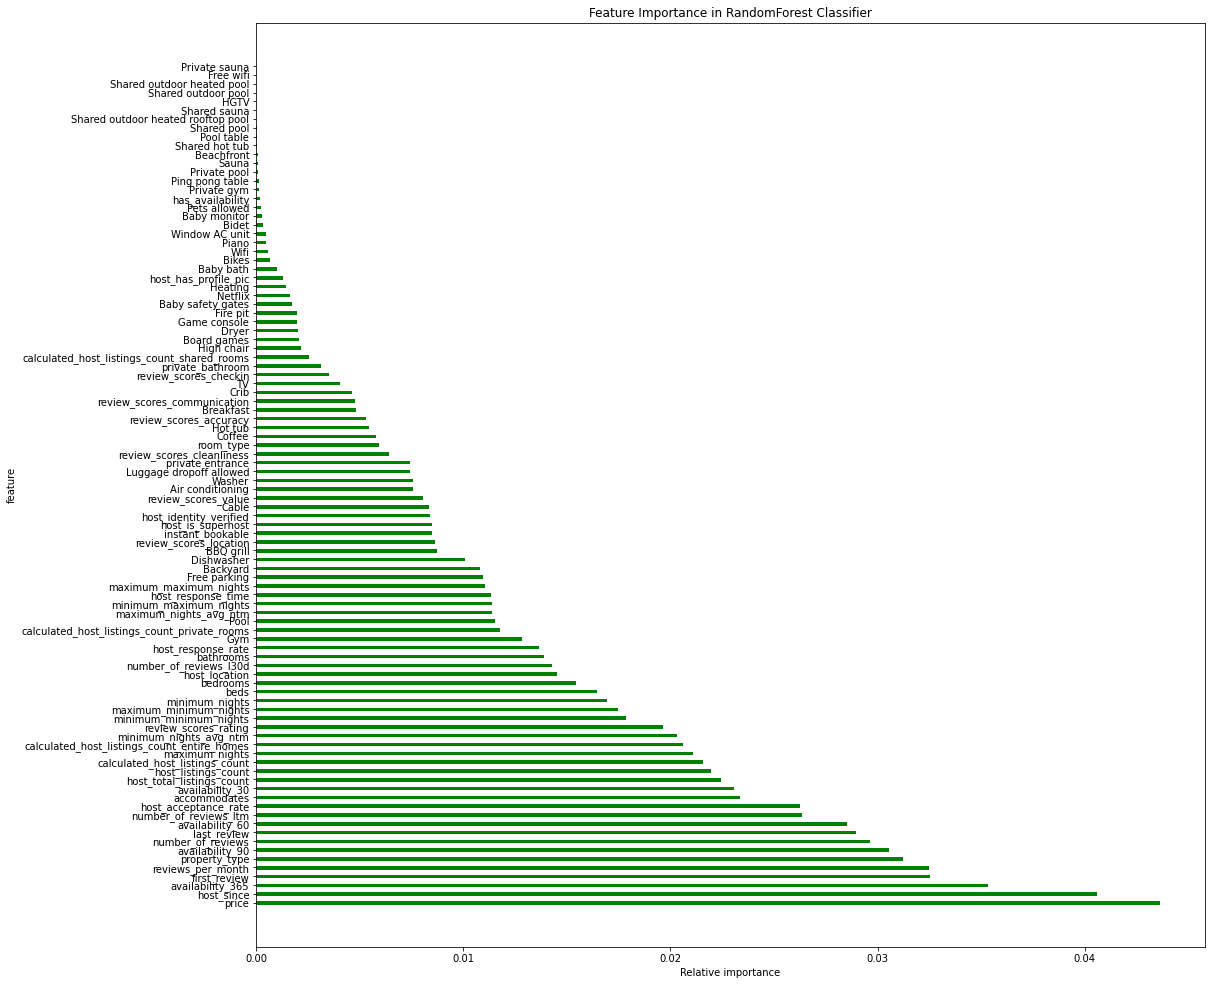

<Figure size 1224x1224 with 0 Axes>

In [46]:
col = feature_importance.index
y = feature_importance.importance

# plot feature_importance
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)
plt.title('Feature Importance in RandomForest Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(17,17))
fig.set_size_inches(17, 17, forward=True)

## Model with Iscolated Neighbourhoods

Because the highest accuracy we saw was still under 50% when choosing between 9 neighbourhoods groups. Lets try to iscolate it to 3 nighbourhoods. And since ```price``` was the most importance feature, lets use the ```neighbourhood_groups``` ```Northwest```, ```West```, & ```North``` because they had the highest mean prices, similar median prices, and are all next to each other.

In [47]:
# First we have to check out out categorical mapping from earlier to know what categories these neighbourhoods are in
neighbourhood_group_mapping

{'Central': 0,
 'East': 1,
 'North': 2,
 'Northeast': 3,
 'Northwest': 4,
 'South': 5,
 'Southeast': 6,
 'Southwest': 7,
 'West': 8}

In [48]:
listings_iso = listings.loc[listings["neighbourhood_group"].isin([neighbourhood_group_mapping["Northwest"], neighbourhood_group_mapping["West"], neighbourhood_group_mapping["North"]])]

# Dependent variable: neighbourhood_group
y = listings_iso['neighbourhood_group']

# Drop dependent variable and other variables that would tamper the results
X = listings_iso.drop(['neighbourhood_group', 'id', 'host_id', 'neighbourhood_cleansed', 'coordinates'], axis=1)

In [49]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Model Evaluation 

In [50]:
# Do same process as before where we find best n_estimator in a for loop
evaluation_iso = pd.DataFrame({'n_estimators': [],
                           'Mean Absolute Error':[],
                           'Mean Squared Error':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'Accuracy':[]})

# Make for loop to graph RMSE & Accuracy for different n_estimators
for i in range(5, 201, 5):
    # Make Classifier & Fit
    rf = RandomForestClassifier(n_estimators=i)
    rf.fit(X_train, y_train)
    
    # Predict
    y_pred = rf.predict(X_test)
    
    # Calculate metrics
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    
    # append to evaluation data frame
    r = evaluation_iso.shape[0]
    evaluation_iso.loc[r] = [i,mae,mse,rmse,accuracy]

<AxesSubplot:xlabel='n_estimators'>

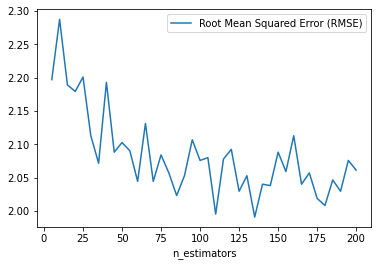

In [51]:
# Plot RMSE
evaluation_iso.plot(kind='line',x='n_estimators',y='Root Mean Squared Error (RMSE)')

<AxesSubplot:xlabel='n_estimators'>

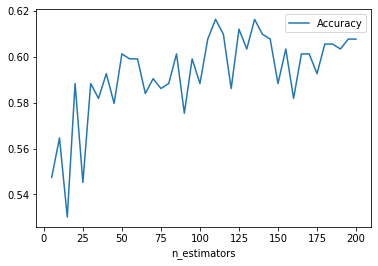

In [52]:
# Plot Accuracy
evaluation_iso.plot(kind='line',x='n_estimators',y='Accuracy')

<AxesSubplot:xlabel='n_estimators'>

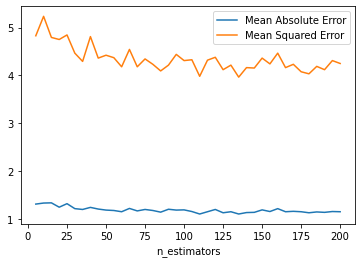

In [53]:
# Plot other Metrics
evaluation_iso.plot(kind='line',x='n_estimators',y=['Mean Absolute Error', 'Mean Squared Error'])

### Model Selection

In [54]:
# Get row in dataframe where accuracy was the highest
best_model_iso = evaluation_iso.sort_values(by = "Accuracy", ascending = False).head(1)
best_model_iso

,n_estimators,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error (RMSE),Accuracy
21,110.0,1.112069,3.982759,1.995685,0.616379


In [55]:
best_n_iso = int(best_model_iso['n_estimators'].iloc[0])
print("We saw best performace on a RandomForestClassifier with n_estimators = ", best_n_iso)

We saw best performace on a RandomForestClassifier with n_estimators =  110


In [56]:
# Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=best_n_iso)

# Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=110)

In [57]:
y_pred = rf.predict(X_test)
y_pred

array([4, 8, 4, 2, 4, 4, 4, 8, 2, 2, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4,
       2, 8, 4, 4, 2, 4, 4, 4, 2, 2, 4, 2, 4, 4, 4, 4, 2, 4, 8, 2, 4, 8,
       4, 4, 4, 2, 4, 4, 4, 4, 8, 4, 4, 2, 2, 4, 2, 4, 2, 2, 2, 2, 2, 2,
       2, 2, 4, 4, 4, 4, 4, 4, 2, 2, 2, 4, 8, 4, 2, 2, 2, 4, 2, 4, 4, 2,
       4, 2, 4, 4, 4, 4, 2, 4, 2, 4, 4, 2, 4, 4, 2, 2, 8, 4, 4, 2, 4, 4,
       4, 4, 2, 4, 4, 2, 4, 4, 4, 4, 2, 2, 2, 4, 4, 4, 2, 4, 8, 2, 4, 4,
       2, 4, 4, 4, 4, 8, 4, 4, 4, 4, 2, 4, 4, 4, 8, 4, 4, 4, 4, 2, 2, 4,
       4, 2, 4, 4, 4, 4, 2, 2, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 2, 2,
       2, 4, 4, 2, 2, 4, 4, 8, 2, 4, 4, 2, 4, 2, 4, 4, 4, 4, 2, 4, 2, 4,
       4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 2, 4, 4, 4, 2, 4, 2, 8, 2, 4,
       2, 2, 4, 4, 2, 4, 2, 4, 4, 4, 2, 2, 4, 2, 2, 4, 4, 2, 4, 4, 2, 2,
       2, 2, 4, 4, 2, 2, 4, 4, 4, 4, 2, 2, 2, 4, 4, 4, 4, 4, 2, 4, 4, 2,
       4, 2, 2, 2, 8, 4, 4, 4, 2, 4, 8, 8, 4, 4, 2, 2, 2, 2, 4, 4, 2, 2,
       4, 4, 2, 4, 8, 4, 2, 2, 4, 4, 4, 2, 4, 4, 4,

In [58]:
print('n_estimators = ', best_n_iso)
print('\tMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('\tMean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

n_estimators =  110
	Mean Absolute Error: 1.1637931034482758
	Mean Squared Error: 4.275862068965517
	Root Mean Squared Error: 2.067815772491717


In [59]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Final Accuray: ", accuracy_score(y_test, y_pred))

[[ 87  73   1]
 [ 46 173   4]
 [ 24  34  22]]
              precision    recall  f1-score   support

           2       0.55      0.54      0.55       161
           4       0.62      0.78      0.69       223
           8       0.81      0.28      0.41        80

    accuracy                           0.61       464
   macro avg       0.66      0.53      0.55       464
weighted avg       0.63      0.61      0.59       464

Final Accuray:  0.6077586206896551


In [60]:
# Create DatFrame of Feature importance for our best model.
feature_importance = pd.DataFrame(rf.feature_importances_, X.columns)
feature_importance.columns = ['importance']
feature_importance = feature_importance.sort_values(by = 'importance', ascending = False)

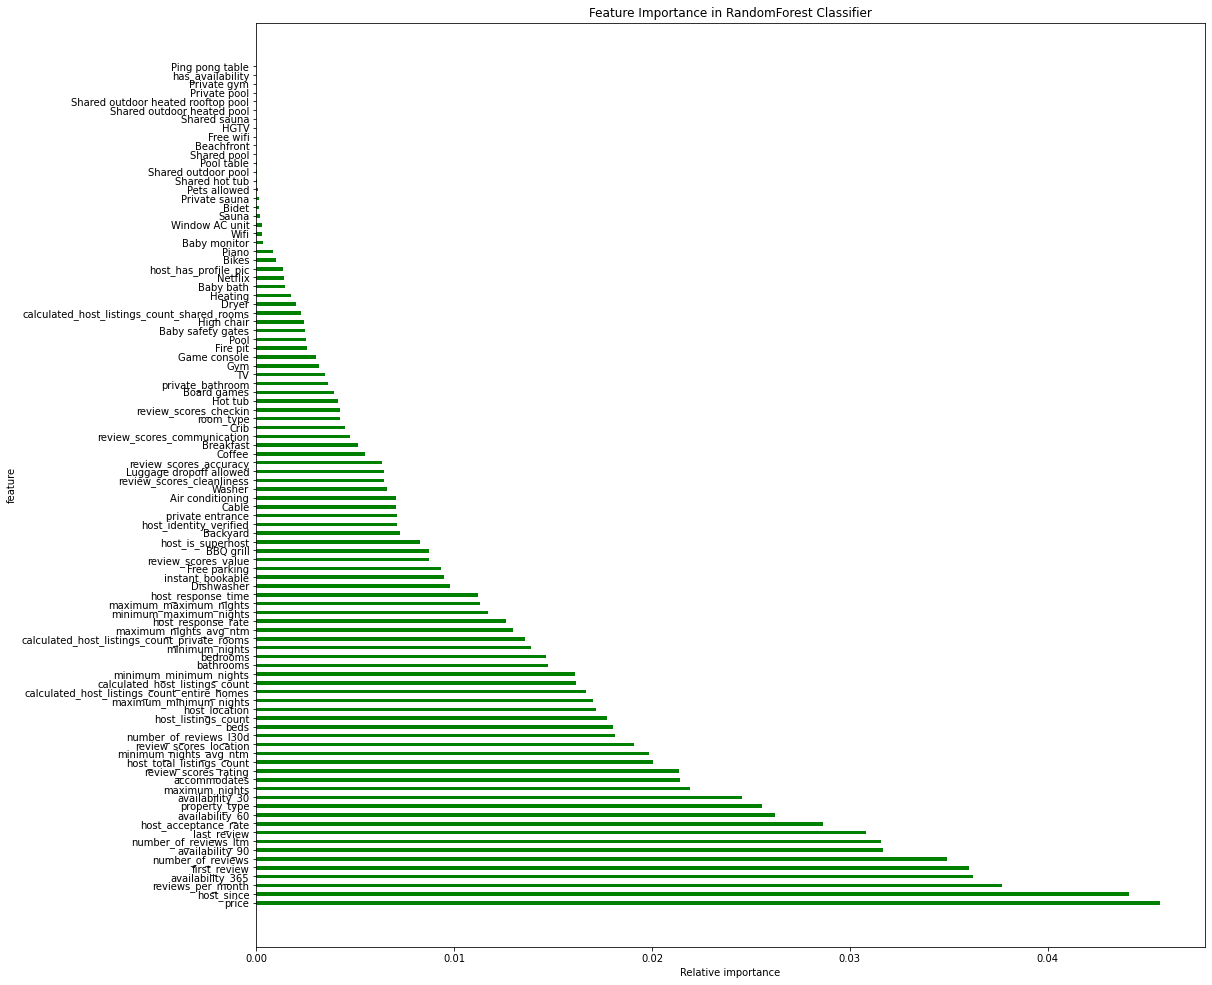

<Figure size 1224x1224 with 0 Axes>

In [61]:
col = feature_importance.index
y = feature_importance.importance

# plot feature_importance
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)
plt.title('Feature Importance in RandomForest Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(17,17))
fig.set_size_inches(17, 17, forward=True)

By isolating the neighbourhood groups the accuracy went up by over 10%! 